In [2]:
import numpy as np
import torch as T
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import pandas as pd
import matplotlib.pyplot as plt

In [3]:
df_train = pd.read_csv('train.csv')
df_test = pd.read_csv('test.csv')

In [4]:
from sklearn.preprocessing import LabelEncoder
# apply label encoding to object columns
# train
object_columns = df_train.select_dtypes(include=['object']).columns
label_encoder = LabelEncoder()
for col in object_columns:
    df_train[col] = label_encoder.fit_transform(df_train[col])
# test
object_columns1 = df_test.select_dtypes(include=['object']).columns
label_encoder = LabelEncoder()
for col in object_columns1:
    df_test[col] = label_encoder.fit_transform(df_test[col])

In [5]:
class Model(nn.Module):
    def __init__(self):
        super(Model, self).__init__()

        lr = 0.00025
        fc1_dims = 64
        fc2_dims = 32
        fc3_dims = 16
        fc4_dims = 8
        input_dims = 18
        self.num_classes = 3
        
        self.fc1 = nn.Linear(input_dims, fc1_dims)
        self.fc2 = nn.Linear(fc1_dims, fc2_dims)
        self.fc3 = nn.Linear(fc2_dims, fc3_dims)
        self.fc4 = nn.Linear(fc3_dims, fc4_dims)
        self.out = nn.Linear(fc4_dims, self.num_classes)

        self.optimizer = optim.Adam(self.parameters(), lr=lr)
        self.device = T.device("cuda:0" if T.cuda.is_available() else "cpu")
        self.loss = nn.MSELoss()
        self.to(self.device)

    def forward(self, input):
        p = self.fc1(input)
        p = F.dropout(p, 0.3)
        p = F.gelu(p)
        p = self.fc2(p)
        p = F.dropout(p, 0.3)
        p = F.gelu(p)
        p = self.fc3(p)
        p = F.dropout(p, 0.3)
        p = F.gelu(p)
        p = self.fc4(p)
        p = F.gelu(p)
        p = self.out(p)
        p = F.softmax(p)
        return p
    
    def train_batch(self, x, y):
        x = x.to(self.device)
        y = y.to(self.device)
        p = self.forward(x)
        self.train()
        self.optimizer.zero_grad()
        loss = self.loss(p, y)
        loss.backward()
        self.optimizer.step()
        self.eval()
        return loss.item()

In [6]:
from sklearn.preprocessing import OneHotEncoder
y = df_train['Status']
x = df_train.drop(['Status', 'id'],axis=1)

enc = OneHotEncoder()
y = y.to_numpy().reshape(-1, 1)
enc.fit(y)
y = enc.transform(y).toarray()
x = x.to_numpy(dtype=float)


C:\Users\TRC8DD~1.DES\AppData\Local\Temp/ipykernel_9528/3523247259.py:37: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  p = F.softmax(p)


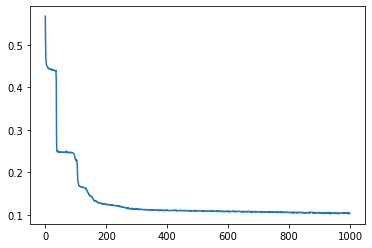

In [9]:
model = Model()
losses = []
batch_size = 64
epoch_count = 1000

for i in range(epoch_count):
    epoc_losses = []
    for j in range(int(x.shape[0] / batch_size)):
        x_ = T.tensor(x[j*batch_size:(j+1)*batch_size], dtype=T.float32)
        y_ = T.tensor(y[j*batch_size:(j+1)*batch_size], dtype=T.float32)
        epoc_losses.append(model.train_batch(x_, y_))
    losses.append(np.mean(epoc_losses))

plt.plot(losses)

In [ ]:
submission = pd.DataFrame()
submission['id'] = df_test['id']
Status_C = []
Status_CL = []
Status_D = []

x = df_test.drop(['id'],axis=1).to_numpy(dtype=float)
for i in range(x.shape[0]):
    x_ = T.tensor(x[i], dtype=T.float32)
    p = model.forward(x_.to(model.device))
    Status_C.append(p[0].item())
    Status_CL.append(p[1].item())
    Status_D.append(p[2].item())

submission['Status_C'] = Status_C
submission['Status_CL'] = Status_CL
submission['Status_D'] = Status_D
submission.to_csv('submission.csv', index=False)

C:\Users\TRC8DD~1.DES\AppData\Local\Temp/ipykernel_16900/3523247259.py:37: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  p = F.softmax(p)
